In [1]:
import sys
sys.path.insert(1, '/home/patryk_mscwrona/repos') # inserting a library's directory

from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt

from river import optim
from river import linear_model
from river import forest
from river import tree
from river import ensemble
from river import preprocessing
from river import metrics
from river import dummy
from river import utils
from river import drift
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (18, 18),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

from Fleuve.master import stream_miner_master
from Fleuve.master import evaluator_master
from Fleuve.master import predictor_master
from Fleuve.master import drift_detector_master


from Fleuve.evaluation.initialize_scripts.initialize_agrawal import InitializeA1
from Fleuve.evaluation.initialize_scripts.initialize_agrawal import InitializeA2
from Fleuve.evaluation.initialize_scripts.initialize_agrawal import InitializeA3
from Fleuve.evaluation.initialize_scripts.initialize_agrawal import InitializeA4



# input data schema
input_schema = StructType([StructField("s",DoubleType(),True), \
    StructField("c",DoubleType(),True), \
    StructField("age",DoubleType(),True), \
    StructField("e", DoubleType(), True), \
    StructField("car", DoubleType(), True), \
    StructField("z", DoubleType(), True), \
    StructField("hv",DoubleType(),True), \
    StructField("hy",DoubleType(),True), \
    StructField("l", DoubleType(), True), \
    StructField("Class", DoubleType(), True)])



# path to stream miner worker files (transfered to workers within a spark context):
sc = SparkContext.getOrCreate()
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/evaluator.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/evaluator_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/drift_detector.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/drift_detector_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/stream_miner.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/stream_miner_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/predictor.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/predictor_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/caching.py")





#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ["HoeffdingTreeClassifier_cluster-9e14-w-0_456478.pkl",
                                                  "HoeffdingTreeClassifier_cluster-9e14-w-0_456507.pkl",
                                                  "HoeffdingTreeClassifier_cluster-9e14-w-0_487791.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_451965.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_486601.pkl"
                                                  ]}, 
        "cluster-9e14-w-1" : {"pretrained_models": ["HoeffdingTreeClassifier_cluster-9e14-w-0_456478.pkl",
                                                      "HoeffdingTreeClassifier_cluster-9e14-w-0_456507.pkl",
                                                      "HoeffdingTreeClassifier_cluster-9e14-w-0_487791.pkl",
                                                      "HoeffdingTreeClassifier_cluster-9e14-w-1_451965.pkl",
                                                      "HoeffdingTreeClassifier_cluster-9e14-w-1_486601.pkl"]}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [metrics.Accuracy(), metrics.BalancedAccuracy(), metrics.F1(), metrics.CohenKappa()]}

data_cols = [field.name for field in input_schema.fields][:-1]


    
spark = SparkSession \
        .builder \
        .appName("Benchmark2") \
        .getOrCreate()


em = evaluator_master.EvaluatorMaster(data_cols, task)

output_schema = em.output_schema


df = spark.read.format("csv").schema(schema = output_schema) \
    .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ev1")

23/08/20 20:28:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Metrics

In [51]:
df = spark.read.format("csv").schema(schema = output_schema) \
    .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ev1")

pdf = df.toPandas()

In [17]:
pdf.columns

Index(['training_time', 'n', 'hostname', 'hash', 'model_name', 'prediction',
       'Accuracy', 'BalancedAccuracy', 'F1', 'CohenKappa', 'model_name_2',
       'prediction_2', 'Accuracy_2', 'BalancedAccuracy_2', 'F1_2',
       'CohenKappa_2', 'model_name_3', 'prediction_3', 'Accuracy_3',
       'BalancedAccuracy_3', 'F1_3', 'CohenKappa_3', 'model_name_4',
       'prediction_4', 'Accuracy_4', 'BalancedAccuracy_4', 'F1_4',
       'CohenKappa_4', 'model_name_5', 'prediction_5', 'Accuracy_5',
       'BalancedAccuracy_5', 'F1_5', 'CohenKappa_5'],
      dtype='object')

In [13]:
pdf.shape

(400000, 34)

In [18]:
pdf.groupby(["hostname", "hash"])["n"].max()

hostname          hash            
cluster-9e14-w-1  pk0hm2fcvvekzehc    400000
Name: n, dtype: int32

In [21]:
pdf.iloc[pdf.shape[0]-1, :]

training_time                      122.455742
n                                      400000
hostname                     cluster-9e14-w-1
hash                         pk0hm2fcvvekzehc
model_name            HoeffdingTreeClassifier
prediction                                1.0
Accuracy                              0.89988
BalancedAccuracy                      0.89988
F1                                   0.903602
CohenKappa                            0.79976
model_name_2          HoeffdingTreeClassifier
prediction_2                              1.0
Accuracy_2                           0.901083
BalancedAccuracy_2                   0.901083
F1_2                                 0.904807
CohenKappa_2                         0.802165
model_name_3          HoeffdingTreeClassifier
prediction_3                              1.0
Accuracy_3                           0.899732
BalancedAccuracy_3                   0.899732
F1_3                                 0.903171
CohenKappa_3                      

In [52]:

acc = []
bacc = []
f1 = []
kappa = []




In [53]:
acc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["Accuracy"],  pdf.iloc[pdf.shape[0]-1, :]["Accuracy_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_3"], pdf.iloc[pdf.shape[0]-1, :]["Accuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_5"]]))
bacc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy"],  pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_3"], pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_5"]]))
f1.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["F1"],  pdf.iloc[pdf.shape[0]-1, :]["F1_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["F1_3"], pdf.iloc[pdf.shape[0]-1, :]["F1_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["F1_5"]]))
kappa.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["CohenKappa"],  pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_3"], pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_5"]]))


In [54]:
df = spark.read.format("csv").schema(schema = output_schema) \
    .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ev2")

pdf = df.toPandas()
print(pdf.groupby(["hostname", "hash"])["n"].max())

acc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["Accuracy"],  pdf.iloc[pdf.shape[0]-1, :]["Accuracy_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_3"], pdf.iloc[pdf.shape[0]-1, :]["Accuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_5"]]))
bacc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy"],  pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_3"], pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_5"]]))
f1.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["F1"],  pdf.iloc[pdf.shape[0]-1, :]["F1_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["F1_3"], pdf.iloc[pdf.shape[0]-1, :]["F1_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["F1_5"]]))
kappa.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["CohenKappa"],  pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_3"], pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_5"]]))


hostname          hash            
cluster-9e14-w-1  wdb736j2snp5q73h    400000
Name: n, dtype: int32


In [55]:
df = spark.read.format("csv").schema(schema = output_schema) \
    .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ev3")

pdf = df.toPandas()
print(pdf.groupby(["hostname", "hash"])["n"].max())

pdf = pdf[pdf["hash"] == "1yv4mav8d4gc99ul"].reset_index(drop=True)

acc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["Accuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_5"]]))
bacc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_5"]]))
f1.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["F1_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["F1_5"]]))
kappa.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_5"]]))


hostname          hash            
cluster-9e14-w-0  1yv4mav8d4gc99ul    232500
cluster-9e14-w-1  9q5dye23z144c8ge     77500
                  cz143mmmkfbegxc0     90000
Name: n, dtype: int32


In [56]:
df = spark.read.format("csv").schema(schema = output_schema) \
    .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ev4")

pdf = df.toPandas()
print(pdf.groupby(["hostname", "hash"])["n"].max())

acc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["Accuracy"],  pdf.iloc[pdf.shape[0]-1, :]["Accuracy_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_3"], pdf.iloc[pdf.shape[0]-1, :]["Accuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_5"]]))
bacc.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy"],  pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_3"], pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["BalancedAccuracy_5"]]))
f1.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["F1"],  pdf.iloc[pdf.shape[0]-1, :]["F1_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["F1_3"], pdf.iloc[pdf.shape[0]-1, :]["F1_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["F1_5"]]))
kappa.append(np.mean([pdf.iloc[pdf.shape[0]-1, :]["CohenKappa"],  pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_3"], pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["CohenKappa_5"]]))


hostname          hash            
cluster-9e14-w-1  lwy0tehlb5ojw2vb    400000
Name: n, dtype: int32


In [10]:
df = spark.read.format("csv").schema(schema = output_schema) \
    .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ev3")

pdf = df.toPandas()

In [11]:
pdf.head()

training_time      n          hostname              hash  \
0      31.233810  77501  cluster-9e14-w-0  1yv4mav8d4gc99ul   
1      31.234512  77502  cluster-9e14-w-0  1yv4mav8d4gc99ul   
2      31.235176  77503  cluster-9e14-w-0  1yv4mav8d4gc99ul   
3      31.235857  77504  cluster-9e14-w-0  1yv4mav8d4gc99ul   
4      31.236477  77505  cluster-9e14-w-0  1yv4mav8d4gc99ul   

                model_name  prediction  Accuracy  BalancedAccuracy        F1  \
0  HoeffdingTreeClassifier         1.0  0.500006               0.5  0.666672   
1  HoeffdingTreeClassifier         1.0  0.500000               0.5  0.666667   
2  HoeffdingTreeClassifier         1.0  0.500006               0.5  0.666672   
3  HoeffdingTreeClassifier         1.0  0.500000               0.5  0.666667   
4  HoeffdingTreeClassifier         1.0  0.500006               0.5  0.666672   

   CohenKappa  ... Accuracy_4  BalancedAccuracy_4      F1_4  CohenKappa_4  \
0         0.0  ...   0.893472            0.893472  0.897319      0.786944   
1         0.0  ...   0.893474            0.893474  0.897319      0.786947   
2         0.0  ...   0.893475            0.893475  0.897321      0.786950   
3         0.0  ...   0.893476            0.893476  0.897321      0.786953   
4         0.0  ...   0.893478            0.893477  0.897324      0.786955   

              model_name_5  prediction_5 Accuracy_5  BalancedAccuracy_5  \
0  HoeffdingTreeClassifier           1.0   0.895769            0.895769   
1  HoeffdingTreeClassifier           0.0   0.895770            0.895770   
2  HoeffdingTreeClassifier           1.0   0.895772            0.895771   
3  HoeffdingTreeClassifier           0.0   0.895773            0.895773   
4  HoeffdingTreeClassifier           1.0   0.895774            0.895774   

       F1_5  CohenKappa_5  
0  0.898828      0.791538  
1  0.898828      0.791541  
2  0.898830      0.791543  
3  0.898830      0.791546  
4  0.898833      0.791549  

[5 rows x 34 columns]

In [16]:
pdf.groupby("hash")["Accuracy"].min()

hash
1yv4mav8d4gc99ul    0.5
9q5dye23z144c8ge    0.5
cz143mmmkfbegxc0    0.5
Name: Accuracy, dtype: float32

In [18]:
print(pdf.groupby(["hostname", "hash"])["n"].max())

hostname          hash            
cluster-9e14-w-0  1yv4mav8d4gc99ul    232500
cluster-9e14-w-1  9q5dye23z144c8ge     77500
                  cz143mmmkfbegxc0     90000
Name: n, dtype: int32


In [19]:
pdf = pdf[pdf["hash"] == "1yv4mav8d4gc99ul"]

In [22]:
([pdf.iloc[pdf.shape[0]-1, :]["Accuracy"],  pdf.iloc[pdf.shape[0]-1, :]["Accuracy_2"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_3"], pdf.iloc[pdf.shape[0]-1, :]["Accuracy_4"],
                   pdf.iloc[pdf.shape[0]-1, :]["Accuracy_5"]])

[0.5, 0.5, 0.5, 0.89347094, 0.89576775]

In [25]:
np.quantile(pdf.Accuracy_2, q =[0.1,0.3,0.5,0.7,0.9])

array([0.5       , 0.5       , 0.50000107, 0.50000358, 0.50001073])

In [21]:
pdf.Accuracy.max()

1.0

In [57]:
acc

[0.900751, 0.8976469, 0.89461935, 0.89065397]

In [62]:
f1

[0.9042031, 0.90071404, 0.8980706, 0.8938848]

#### replay

In [65]:
acc

[0.900751, 0.8976469, 0.89461935, 0.89065397]

In [67]:
bacc

[0.900751, 0.8976469, 0.89461935, 0.89065397]

In [63]:
f1

[0.9042031, 0.90071404, 0.8980706, 0.8938848]

In [68]:
kappa

[0.80150205, 0.795294, 0.7892387, 0.781308]

## Training time

In [26]:
# input data schema
input_schema = StructType([StructField("s",DoubleType(),True), \
    StructField("c",DoubleType(),True), \
    StructField("age",DoubleType(),True), \
    StructField("e", DoubleType(), True), \
    StructField("car", DoubleType(), True), \
    StructField("z", DoubleType(), True), \
    StructField("hv",DoubleType(),True), \
    StructField("hy",DoubleType(),True), \
    StructField("l", DoubleType(), True), \
    StructField("Class", DoubleType(), True)])



# path to stream miner worker files (transfered to workers within a spark context):
sc = SparkContext.getOrCreate()
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/evaluator.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/evaluator_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/drift_detector.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/drift_detector_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/stream_miner.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/stream_miner_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/predictor.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/shared/predictor_handler.py")
sc.addPyFile("/home/patryk_mscwrona/repos/Fleuve/worker/caching.py")





#SET TASK
task = {"cluster-9e14-w-0": {"models": [tree.HoeffdingTreeClassifier(max_depth = 20)] , 
                             "min_update_freq_s" : 60, 
                             "min_training_instances": 294000}, 
        "cluster-9e14-w-1" : {"models": [tree.HoeffdingTreeClassifier(max_depth = 20)] , 
                             "min_update_freq_s" : 60, 
                             "min_training_instances": 294000}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [metrics.Accuracy()]}

data_cols = [field.name for field in input_schema.fields][:-1]



spark = SparkSession \
            .builder \
            .appName("TrainingTimeAnalysis") \
            .getOrCreate()
    

sm = stream_miner_master.StreamMinerMaster(data_cols, task)


sm.output_schema

23/08/20 20:43:01 WARN SparkContext: The path /home/patryk_mscwrona/repos/Fleuve/worker/evaluator.py has been added already. Overwriting of added paths is not supported in the current version.
23/08/20 20:43:01 WARN SparkContext: The path /home/patryk_mscwrona/repos/Fleuve/shared/evaluator_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/08/20 20:43:01 WARN SparkContext: The path /home/patryk_mscwrona/repos/Fleuve/worker/drift_detector.py has been added already. Overwriting of added paths is not supported in the current version.
23/08/20 20:43:01 WARN SparkContext: The path /home/patryk_mscwrona/repos/Fleuve/shared/drift_detector_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/08/20 20:43:01 WARN SparkContext: The path /home/patryk_mscwrona/repos/Fleuve/worker/stream_miner.py has been added already. Overwriting of added paths is not supported in the current version.
23/08/

StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('Accuracy', FloatType(), False)])

In [27]:

ex = [[1, 400000], [2,200000], [3,133333], [4,100000]]

cases = [1,2,3,4,5]

mean_time_in_seconds = []

for e in ex:
    results = []
    for case in cases:

        sdf = spark.read.format("csv").schema(schema = output_schema)\
            .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ex" + str(e[0]) +"/case" + str(case))

        pdf = sdf.toPandas()

        s_scaled = pdf.groupby("hash")["training_time"].max().sum()/pdf.groupby("hash")["n"].max().sum()*e[1]
                                          
        results.append(s_scaled)

    mean_time_in_seconds.append(np.mean(results))
                                          

                                          

In [73]:
mean_time_in_seconds

[127.01840891520183, 61.36470433553061, 41.20121172788721, 14.228574218750001]

#### Replay

In [28]:
mean_time_in_seconds

[117.61616658528646, 64.44156422932943, 43.911710593984225, 32.5243446858724]

In [60]:
aux= mean_time_in_seconds

In [76]:

ex = [[4,100000]]

cases = [1,2,3,4,5]

mean_time_in_seconds = []

for e in ex:
    results = []
    for case in cases:

        sdf = spark.read.format("csv").schema(schema = output_schema)\
            .options(header='false').load("hdfs://cluster-9e14-m/user/hdfs/evaluation/ex" + str(e[0]) +"/case" + str(case))

        pdf = sdf.toPandas()

        s_scaled = pdf.groupby("hash")["training_time"].max().sum()/pdf.groupby("hash")["n"].max().sum()*e[1]
                                          
        results.append(s_scaled)

    mean_time_in_seconds.append(np.mean(results))

In [77]:
mean_time_in_seconds # second attempt

[14.10363363901774]

In [65]:
pdf = sdf.toPandas()

In [60]:
pdf.groupby("hash")["n"].max()

hash
62x768oru7gdmlog    542500
775w5ibpbsfq7uf3    477500
jd3hrwbko92d0ftd    490000
tde2ij5tww17hn2q    490000
Name: n, dtype: int32

In [66]:
pdf.groupby("hash")["n"].max()

hash
0bhbcujfjbw6q95l    12500
1jc1vphlr9u5sela    77500
1qi5kaymh0345q0x    77500
gcwqrj2lgcckhu8p    77500
huipl955sbljmmny    77500
mgpok7utzbjssyus    77500
Name: n, dtype: int32

In [63]:
pdf.groupby("hash")["n"].max()

hash
0bhbcujfjbw6q95l    212500
1jc1vphlr9u5sela    277500
1qi5kaymh0345q0x    277500
5t0uid44bi7xdl26    200000
gcwqrj2lgcckhu8p    277500
huipl955sbljmmny    277500
lhigl2c1mozp7n68    200000
mgpok7utzbjssyus    277500
Name: n, dtype: int32

In [67]:
pdf.groupby("hash")["n"].max().sum()

400000

In [68]:
pdf.groupby("hash")["training_time"].max().sum()

186.65312

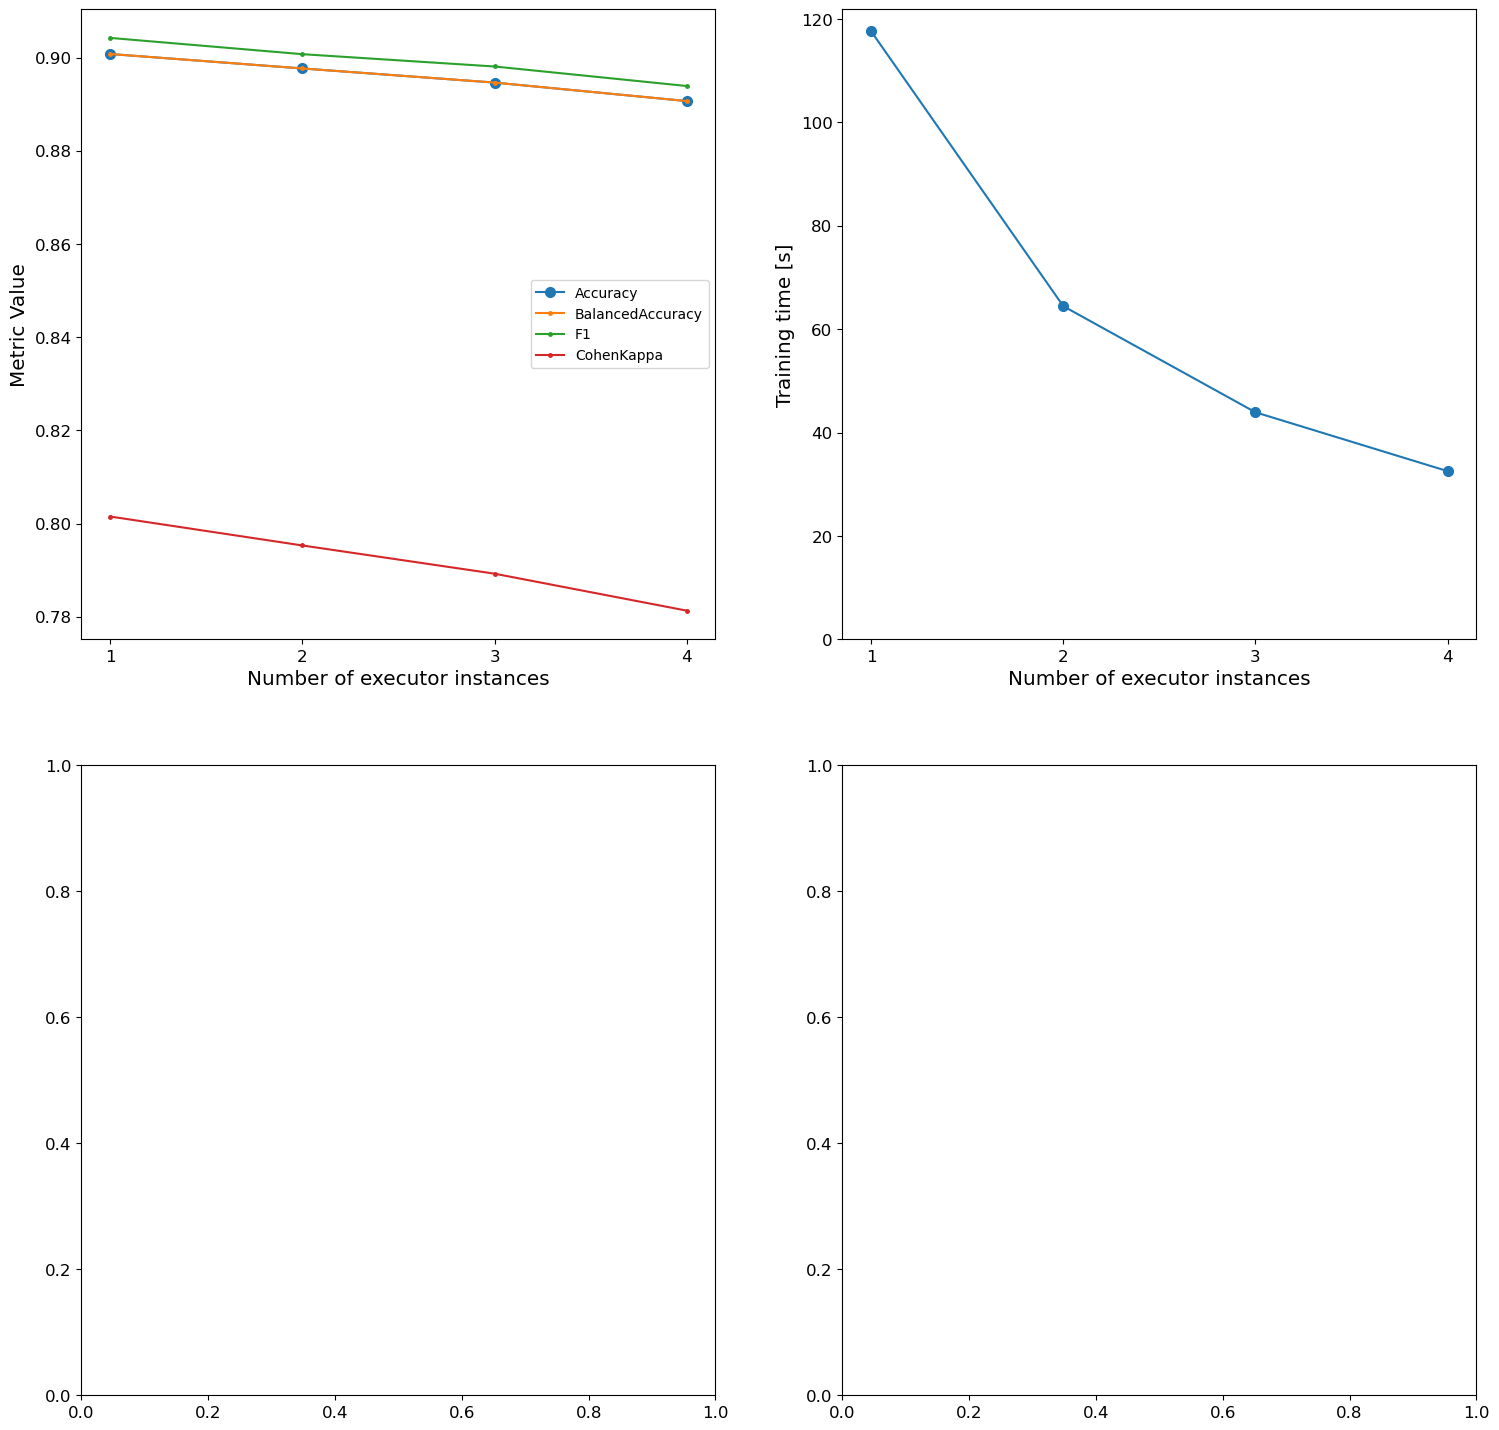

In [70]:
fig, axs = plt.subplots(2, 2)
v = [1,2,3,4]

# metrics
axs[0, 0].plot(v, acc, marker='o', markersize = 7)
axs[0, 0].plot(v, bacc, marker='.', markersize = 5)
axs[0, 0].plot(v, f1, marker='.', markersize = 5)
axs[0, 0].plot(v, kappa, marker='.', markersize = 5)
axs[0, 0].legend( ['Accuracy','BalancedAccuracy', 'F1', 'CohenKappa'], loc = 'right')
axs[0, 0].set_xticks(v)
# axs[0, 0].set_title('Evaluation metrics')

# training time
axs[0, 1].plot(v, aux, marker='o', markersize = 7)
axs[0, 1].set_xticks(v)
# axs[0, 1].set_title('Training time')


counter = 0
for ax in axs.flat:
    
    if counter == 0:
        ax.set(xlabel='Number of executor instances', ylabel='Metric Value')
    if counter == 1:
        ax.set(xlabel='Number of executor instances', ylabel='Training time [s]', yticks = [0, 20, 40, 60, 80, 100, 120])    
        
        
    counter+=1
